### Forecasting Spare parts inventory

### Aathavan A P
### aathavanx4@gmail.com
 


## Business Case 
- have to create predictive model for inventory forecasting of Bajaj bike service center so they can have spare parts in stock beforehand.

In [584]:
# Basic libraries 

import os
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
from matplotlib.pyplot import figure
import missingno as msno
import sweetviz as sv
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import simple_colors
from sqlalchemy import create_engine
import datetime as dt
from datetime import datetime


## Connecting to database through SQL librairy

In [585]:
db_host='18.136.157.135'
username='dm_usdata_sql'
user_pass='37z<49REb&mKnl4AV!vJ'
db_name='project_service_data'

In [586]:
conn = create_engine('mysql+pymysql://'+username+':'+user_pass+'@'+db_host+'/'+db_name)
conn.table_names()

['service_data']

In [587]:
query = 'select * from service_data'
df = pd.read_sql(query,conn)
df.shape

(28482, 7)

In [588]:
query = 'select * from service_data'
df_O = pd.read_sql(query,conn) # for comparing in future after cleaning df
df_O.shape

(28482, 7)

# EDA

In [589]:
df.columns

Index(['invoice_date', 'job_card_date', 'business_partner_name', 'vehicle_no',
       'vehicle_model', 'current_km_reading', 'invoice_line_text'],
      dtype='object')

In [590]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28482 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   invoice_date           28482 non-null  object
 1   job_card_date          28482 non-null  object
 2   business_partner_name  28482 non-null  object
 3   vehicle_no             28482 non-null  object
 4   vehicle_model          28482 non-null  object
 5   current_km_reading     28482 non-null  object
 6   invoice_line_text      28476 non-null  object
dtypes: object(7)
memory usage: 1.5+ MB


In [591]:
df.describe()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
count,28482,28482,28482,28482,28482,28482,28476
unique,555,553,1010,846,28,3474,503
top,01-12-18,01-12-18,venkXXXXXXXXXX,KA53EVXXXX,BAJAJ PULSAR 150,0,ENGINE OIL
freq,179,179,424,1313,8633,842,3802


In [592]:
# we import
import dtale

In [593]:
dtale.show(df)
# Univariate Analysis
# Bivariate Analysis
# Multivariate Analysis

## Insights from EDA 



#### invoice_date
- its the data that bill was printed

#### job_card_date
- its a date that spare part is being replaced

#### business_partner_name
- name of the business partner (client) who is in need of spare parts
- dataset contains 1,010 client details
- venkXXXXXXXXXX is the frequent client ,serviced bike 416 time

#### vehicle_no
- vechicle that needs part replacement or service

#### vehicle_model
- model of the vehicle
- there is 28 models of bikes
- all bikes are from bajaj company, which means it's a bajaj bike showroom and service center
- BAJAJ PULSAR 150 is the frequent serviced bike model

#### current_km_reading
- vehicle runned km on the day of job_card_date (service or delivery)
- some records have 0 km

#### invoice_line_text
- it denotes the spare part that being replaced on job_card_date (service or delivery)



# Column 0&1 : invoice_date & job_card_date
- as of now im keeping them as they are 
- cause for regression and time series model , I've to use different technique to change them

# Column 2 : business_partner_name

In [594]:
dtale.show(df['business_partner_name'].unique()) #1010 #1010 #1007 #796 #796


In [595]:
print(df['business_partner_name'].loc[df['business_partner_name'].str.len()==0].count()) # checking for 0 len string 

0


In [596]:
df['business_partner_name'] = df['business_partner_name'].str.replace('X', '') #replacing all X with empty string

In [597]:
 df['business_partner_name'] = df['business_partner_name'].str.replace(' ', '') #replacing all space with empty string

In [598]:
df['business_partner_name'] = df['business_partner_name'].str.upper() # changing all letters to uppercase

In [599]:
df['business_partner_name'] = df['business_partner_name'].str.strip() #removing space before and after the string

In [600]:
df['has_non_alpha'] = df['business_partner_name'].apply(lambda x: not x.isalpha())
df[df['has_non_alpha'] == True] # checking string contains any other characters like numbers and special characters

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text,has_non_alpha


In [601]:
df=df.drop(columns=['has_non_alpha']) # droping this column after the checking

In [602]:
max_string_len = df['business_partner_name'].apply(lambda x: len(x)).max()
print(max_string_len) # checking whats the max len in business_partner_name column

4


# Column 3 : vehicle_no

In [603]:
df['vehicle_no'].nunique()

846

In [604]:
dtale.show(df['vehicle_no'].unique()) 

In [605]:
print(df['vehicle_no'].loc[df['vehicle_no'].str.len()==0].count()) 

0


In [606]:
df['vehicle_no'] = df['vehicle_no'].str.strip()

In [607]:
df['vehicle_no'] = df['vehicle_no'].str.upper()

In [608]:
df['vehicle_no'] = df['vehicle_no'].str.replace(' ', '')

In [609]:
df['vehicle_no'] = df['vehicle_no'].str.replace('X', '')

# Column 4 : vehicle_model

In [610]:
df['vehicle_model'].nunique()

28

In [611]:
dtale.show(df['vehicle_model'].unique()) 

In [612]:
print(df['vehicle_model'].loc[df['vehicle_model'].str.len()==0].count())

0


In [613]:
df['vehicle_model'] = df['vehicle_model'].str.strip()

In [614]:
df['vehicle_model'] = df['vehicle_model'].str.replace(' ', '_')

In [615]:
df['vehicle_model'] = df['vehicle_model'].str.upper()

# Column 5 : current_km_reading

In [616]:
df['current_km_reading']=df['current_km_reading'].astype('int')

In [617]:
df['current_km_reading'].nunique()

3474

In [618]:
pd.DataFrame(df['current_km_reading'][df['current_km_reading']>=300000]).count()

current_km_reading    27
dtype: int64

In [619]:
dtale.show(df['current_km_reading'].unique())

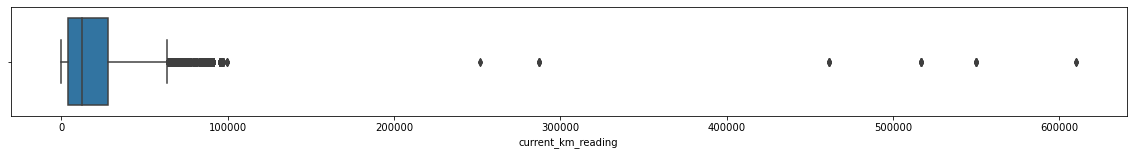

In [620]:
rcParams['figure.figsize'] = 20,2

sns.boxplot(df['current_km_reading']) #boxplot
plt.show()

- first bike service is done after 500 km
- after first service every service is done after 2000km and so on after every 2000km
- An average bike runs 8000 to 10000 km every year
- Bikes used by frequent travelers runs 15000 to 20000 km every year
----------------------------------------------------------------------
- here km cant be 0 and , in some case it can be below 200 if the bike is at fault after the few weeks or months of purchase,
- So, I'm changing values where below 200 to 200
- after that I'm changing values where above
----------------------------------------------------------------------
- as per the dataset maximum km is 600000, if you divide that by 20000(frequent travelers km per year) , you'll get 30 which means its a 30 year old bike
- Since I'm considering this as outliers, I'm changing every value above 300000 to 300000 
- which means (logically by math no bike can't be more than 15 year old) at the same time some bike models like bajaj platina which was released in 2006 and used by normal bike rider can now have high km in odo meter.

In [621]:
df['current_km_reading'] = [200 if x < 200 else x for x in df['current_km_reading']] # changing every value less than 200 to 200

In [622]:
df['current_km_reading'] = [300000 if x > 300000 else x for x in df['current_km_reading']]  # changing every value greater than 300000 to 300000

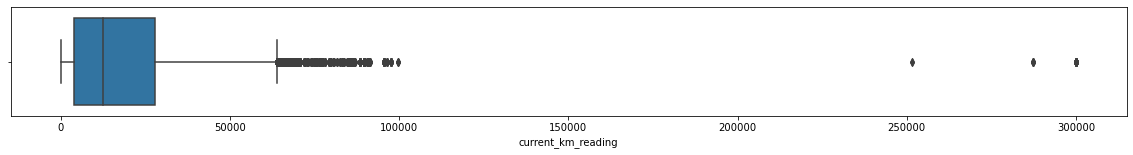

In [623]:
rcParams['figure.figsize'] = 20,2
sns.boxplot(df['current_km_reading']) #boxplot
plt.show()

# Column 6 : invoice_line_text 

#### Removing null values 

In [624]:
df['invoice_line_text'].nunique()

503

In [625]:
dtale.show(df['invoice_line_text'].unique())

In [626]:
df['invoice_line_text'].isnull().sum() # there is 5 null values in column invoice_line_text

6

In [627]:
df.dropna(axis=0, subset=['invoice_line_text'], inplace=True) # removing null values

In [628]:
df['invoice_line_text'].isnull().sum() # there is 0 null values in column invoice_line_textb

0

In [629]:
print(df['invoice_line_text'].loc[df['invoice_line_text'].str.len()==0].count()) # 28 value has 0 string len

28


In [630]:
df.drop(df[df['invoice_line_text'].str.len()==0].index, inplace = True) 
#droped 28 rows where string lenthg is 0 in invoice line text 

In [631]:
df['invoice_line_text']= df['invoice_line_text'].str.upper()

In [632]:
df['invoice_line_text']= df['invoice_line_text'].str.strip()

In [633]:
#pd.reset_option('display.max_rows', None)
df['invoice_line_text'][df['invoice_line_text'].str.contains(' AND ')].count() #32 rows have AND

32

In [634]:
df.drop(df[df['invoice_line_text'].str.contains(' AND ')].index, inplace = True) 
# droping values with ' AND '

In [635]:
df['invoice_line_text'][df['invoice_line_text'].str.contains(' AND ')].count() # checking for AND

0

### Replacing same spare parts name with different spelling

In [636]:
dtale.show(df['invoice_line_text'].unique())

##### these are the same spare parts with different spellings
-----------------------------------------------------------
- MUDGAURD CLAMP == MUDGUARD CLAMP
- SILENCER JALI == SILENCER JALL


In [637]:
df['invoice_line_text'] = df['invoice_line_text'].replace(['MUDGAURD CLAMP'], 'MUDGUARD CLAMP') # replacing with right spelling

In [638]:
df['invoice_line_text'] = df['invoice_line_text'].replace(['SILENCER JALL'], 'SILENCER JALI')

In [639]:
df['invoice_line_text'].nunique()

482

### removing duplicate rows

In [640]:
df.duplicated().sum() 

374

In [641]:
df = df.drop_duplicates(keep='last') # removing 382 duplicate rows 

## Unique value count of original Datafram and cleaned Datafram

In [642]:
df_O.nunique() # Original DataFrame

invoice_date              555
job_card_date             553
business_partner_name    1010
vehicle_no                846
vehicle_model              28
current_km_reading       3474
invoice_line_text         503
dtype: int64

In [643]:
df.nunique() # Cleaned DataFrame

invoice_date              555
job_card_date             553
business_partner_name     796
vehicle_no                846
vehicle_model              28
current_km_reading       3447
invoice_line_text         482
dtype: int64

# Variables for predicting 

#### job_card_date (independent variable)
- its the date for predicting the need of spare parts for future, though invoice date confirms the what are the parts are    replace and their price, we're predicting here beforhand so we'll use job_card_date for prediction

#### invoice_line_text (independent variable)
- spare parts that we need to predict for count 

#### count (dependent variable) 
- I've created this column using groupby function
- count of every spare parts acroding to date

##### removing all other columns
- since there is no specific feature requirement for prediction 
- and business case only requires to predict spare parts for the future use
- Hence I'm removing other columns

In [644]:
df2= df[['job_card_date','invoice_line_text']]
df2 = df2.rename(columns={'job_card_date': 'date', 'invoice_line_text': 'spare'})
df2

,date,spare
0,30-05-17,ENGINE OIL
1,31-05-17,ENGINE OIL
2,31-05-17,POLISH
3,31-05-17,CONSUMABLES
4,31-05-17,COOLANT OIL
...,...,...
28477,06-01-19,SPROCKET RUBBER
28478,06-01-19,CLUTCH CABLE
28479,06-01-19,OIL FILTER
28480,06-01-19,DISC OIL


### Grouping date and adding count column for spare unique values count for each grouped date value

In [645]:
grouped = df2.groupby('date')

# Create an empty DataFrame to store the results
df3 = pd.DataFrame(columns=['date', 'spare', 'count'])

# Iterate over the groups and count the unique values of the spare column for each group
for date, group in grouped:
    # Count the unique values of the spare column
    counts = group['spare'].value_counts()

    # Add the counts to the results DataFrame
    for invoice_line_text, count in counts.items():
            df3 = df3.append({
            'date': date,
            'spare': invoice_line_text,
            'count': count
        }, ignore_index=True)

# Display the results
pd.DataFrame(df3)

,date,spare,count
0,01-02-18,ENGINE OIL,8
1,01-02-18,CHAIN LUBRICATION,8
2,01-02-18,GENERAL SERVICE,6
3,01-02-18,AIR FILTER,5
4,01-02-18,BRAKE SHOE,4
...,...,...,...
12604,31-12-18,SHIELD SQUARE RUBBER,1
12605,31-12-18,CHAIN ADJUSTER,1
12606,31-12-18,CHAIN ADJUSTER PLATE,1
12607,31-12-18,BRAKE SHOE,1


# Feature Engineering for regressor models

In [646]:
df4 = df3.copy()

In [647]:
df4

,date,spare,count
0,01-02-18,ENGINE OIL,8
1,01-02-18,CHAIN LUBRICATION,8
2,01-02-18,GENERAL SERVICE,6
3,01-02-18,AIR FILTER,5
4,01-02-18,BRAKE SHOE,4
...,...,...,...
12604,31-12-18,SHIELD SQUARE RUBBER,1
12605,31-12-18,CHAIN ADJUSTER,1
12606,31-12-18,CHAIN ADJUSTER PLATE,1
12607,31-12-18,BRAKE SHOE,1


In [648]:
df4[['day','month','year']]= df4['date'].str.split("-", n = 2, expand = True) # spliting dd-mm-yy to dd , mm, yy columns 

In [649]:
df4.drop(columns=['date'],inplace=True) #droping old date column

In [650]:
df4

,spare,count,day,month,year
0,ENGINE OIL,8,01,02,18
1,CHAIN LUBRICATION,8,01,02,18
2,GENERAL SERVICE,6,01,02,18
3,AIR FILTER,5,01,02,18
4,BRAKE SHOE,4,01,02,18
...,...,...,...,...,...
12604,SHIELD SQUARE RUBBER,1,31,12,18
12605,CHAIN ADJUSTER,1,31,12,18
12606,CHAIN ADJUSTER PLATE,1,31,12,18
12607,BRAKE SHOE,1,31,12,18


In [651]:
df4 = df4.astype({'day': 'int32', 'month': 'int32', 'year': 'int32', 'count': 'int32'}) # astyping day,month and year column

In [652]:
from sklearn.preprocessing import LabelEncoder # doing label encoding
LE=LabelEncoder()
df4['spare']=LE.fit_transform(df4['spare'])
df4

,spare,count,day,month,year
0,144,8,1,2,18
1,74,8,1,2,18
2,202,6,1,2,18
3,10,5,1,2,18
4,45,4,1,2,18
...,...,...,...,...,...
12604,375,1,31,12,18
12605,68,1,31,12,18
12606,69,1,31,12,18
12607,45,1,31,12,18


In [653]:
df4.info() #changed every column dtype to int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12609 entries, 0 to 12608
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   spare   12609 non-null  int32
 1   count   12609 non-null  int32
 2   day     12609 non-null  int32
 3   month   12609 non-null  int32
 4   year    12609 non-null  int32
dtypes: int32(5)
memory usage: 246.4 KB


In [654]:
df4.describe() # checking for constant variable, there is none

,spare,count,day,month,year
count,12609.000000,12609.000000,12609.000000,12609.000000,12609.000000
mean,192.207074,2.223967,15.568959,7.558569,17.699976
std,143.550617,2.103891,8.960194,3.223671,0.482893
min,0.000000,1.000000,1.000000,1.000000,17.000000
25%,78.000000,1.000000,7.000000,5.000000,17.000000
50%,144.000000,1.000000,16.000000,8.000000,18.000000
75%,314.000000,3.000000,23.000000,10.000000,18.000000
max,481.000000,17.000000,31.000000,12.000000,19.000000


## Checking Outliers

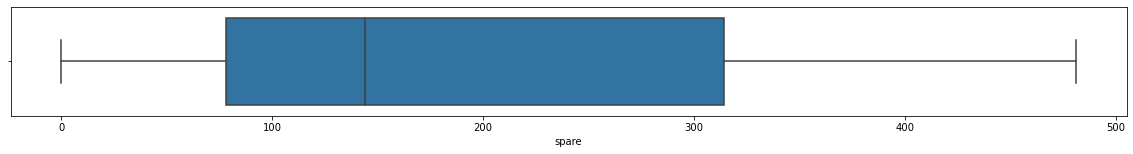

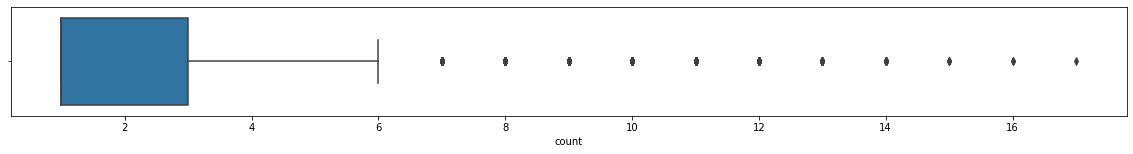

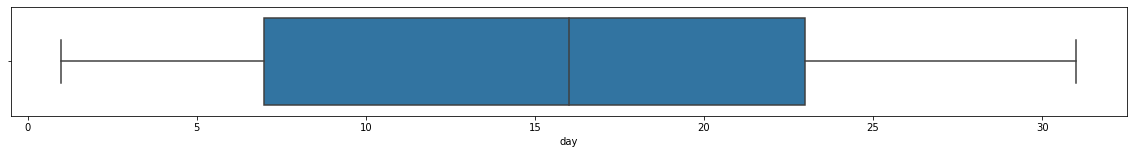

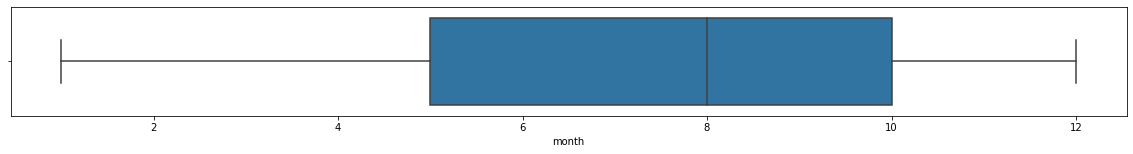

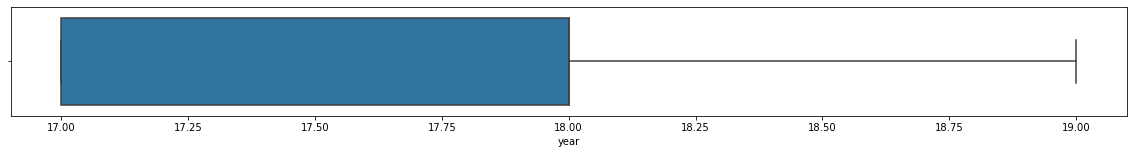

In [655]:
for i in df4:
    sns.boxplot(df4[i]) #boxplot
    plt.show()

- Not removing outliers in count column, tried removing them using above code and ran the models , it did'nt improve r2 score , I'm keeping them as it is.

## Checking Correlations of variables

In [656]:
df4.drop('count',axis=1).corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,spare,day,month,year
spare,1.0,0.00244,0.02962,0.01162
day,0.00244,1.0,0.03902,-0.02498
month,0.02962,0.03902,1.0,-0.3339
year,0.01162,-0.02498,-0.3339,1.0


- Since the variables does'nt have strong relation, I'm keeping them as it is

## Indipendent and Dependent variable Assigning


In [657]:
# Defining X and y and creating dependent and independent variables
X = df4.drop(columns=['count'])       ## independent variable
y = df4[['count']]    ## target variable 

## Scaling Indipendent variable


In [658]:
from sklearn.preprocessing import StandardScaler  # to scale the data
scalar = StandardScaler()                         # objcet creation
X_scaled = scalar.fit_transform(X)                # scaling independent variable

##  Training and Testing Indipendent and Dependent variables

In [659]:
## dividing data into 80% for training and 20% testing 
from sklearn.model_selection import train_test_split # we import this to train and test X and y data
X_train, X_test, y_train, y_test = train_test_split (X_scaled, y, test_size= 0.2, random_state = 42)

## Metrics for evaluating classification model

In [660]:
#for model evalution we import
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import math  #math library to root squre RMSE

## Creating a Global function to estimate models


In [661]:
# importing regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [662]:
def evaluate_regression_models(X_train, X_test, y_train, y_test):
    
    models = [LinearRegression(),DecisionTreeRegressor(),RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),
    GradientBoostingRegressor(),XGBRegressor(),LGBMRegressor(),CatBoostRegressor()]
    
    model_names = ['Linear Regression','Decision Tree Regressor','Random Forest Regressor','AdaBoost Regressor',
    'Bagging Regressor','Gradient Boosting Regressor','XGBoost Regressor','LightGBM Regressor','CatBoost Regressor']
    
    results = pd.DataFrame(columns=['Model', 'R2 Score', 'Adjusted R2', 'MSE', 'RMSE', 'MAE'])
    
    for model, model_name in zip(models, model_names):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        #metrics
        r2 = r2_score(y_test, y_pred)
        n = len(X_test)
        p = X_test.shape[1]
        adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse**0.5
        mae = mean_absolute_error(y_test, y_pred)
       
        # Store the results in the DataFrame
        results = results.append({'Model': model_name, 'R2 Score': r2, 'Adjusted R2': adjusted_r2,
                                  'MSE': mse, 'RMSE': rmse, 'MAE': mae}, ignore_index=True)
        
        # Plot the actual and predicted values
        plt.figure(figsize=(8,2))
        plt.plot(y, label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.title(model_name)
        plt.xlabel('Index')
        plt.ylabel('Target Value')
        plt.legend()
        plt.show()      
    return results    

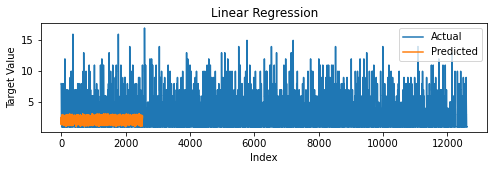

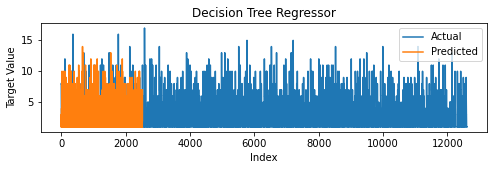

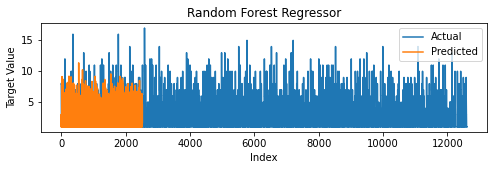

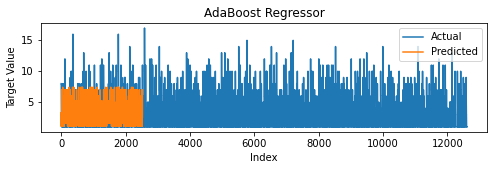

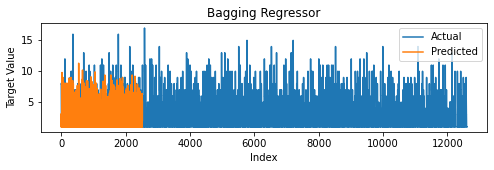

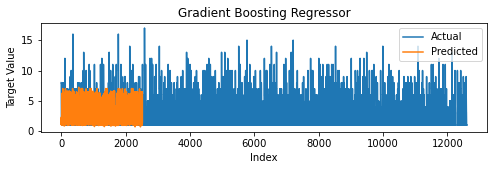

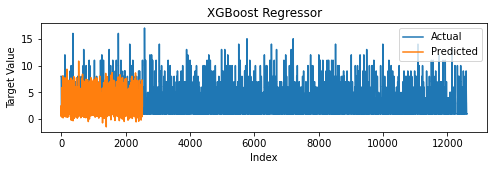

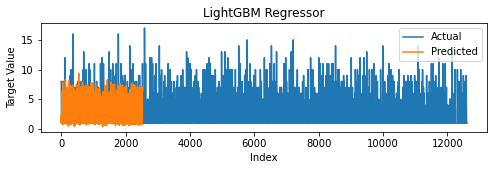

Learning rate set to 0.058989
0:	learn: 2.0490842	total: 4.45ms	remaining: 4.44s
1:	learn: 2.0059062	total: 9.08ms	remaining: 4.53s
2:	learn: 1.9583970	total: 12.6ms	remaining: 4.17s
3:	learn: 1.9214914	total: 16.3ms	remaining: 4.07s
4:	learn: 1.8911296	total: 20.3ms	remaining: 4.05s
5:	learn: 1.8581509	total: 24.2ms	remaining: 4s
6:	learn: 1.8248730	total: 27.7ms	remaining: 3.94s
7:	learn: 1.8035576	total: 31.3ms	remaining: 3.88s
8:	learn: 1.7827295	total: 35.5ms	remaining: 3.91s
9:	learn: 1.7568561	total: 39.8ms	remaining: 3.94s
10:	learn: 1.7372522	total: 44.4ms	remaining: 4s
11:	learn: 1.7157696	total: 48.7ms	remaining: 4.01s
12:	learn: 1.6952483	total: 52.6ms	remaining: 3.99s
13:	learn: 1.6781251	total: 56.7ms	remaining: 3.99s
14:	learn: 1.6682006	total: 61.2ms	remaining: 4.02s
15:	learn: 1.6589878	total: 66.8ms	remaining: 4.11s
16:	learn: 1.6505267	total: 72.4ms	remaining: 4.18s
17:	learn: 1.6392872	total: 76.4ms	remaining: 4.17s
18:	learn: 1.6320682	total: 82.8ms	remaining: 4.27

177:	learn: 1.3560591	total: 684ms	remaining: 3.16s
178:	learn: 1.3556681	total: 687ms	remaining: 3.15s
179:	learn: 1.3552394	total: 691ms	remaining: 3.15s
180:	learn: 1.3548697	total: 695ms	remaining: 3.14s
181:	learn: 1.3541002	total: 698ms	remaining: 3.14s
182:	learn: 1.3536664	total: 701ms	remaining: 3.13s
183:	learn: 1.3528052	total: 705ms	remaining: 3.13s
184:	learn: 1.3521426	total: 708ms	remaining: 3.12s
185:	learn: 1.3514331	total: 712ms	remaining: 3.12s
186:	learn: 1.3509341	total: 716ms	remaining: 3.11s
187:	learn: 1.3503506	total: 720ms	remaining: 3.11s
188:	learn: 1.3495807	total: 723ms	remaining: 3.1s
189:	learn: 1.3490147	total: 726ms	remaining: 3.1s
190:	learn: 1.3481317	total: 730ms	remaining: 3.09s
191:	learn: 1.3470341	total: 734ms	remaining: 3.09s
192:	learn: 1.3466929	total: 738ms	remaining: 3.08s
193:	learn: 1.3460638	total: 742ms	remaining: 3.08s
194:	learn: 1.3450765	total: 746ms	remaining: 3.08s
195:	learn: 1.3444776	total: 749ms	remaining: 3.07s
196:	learn: 1.

361:	learn: 1.2885554	total: 1.37s	remaining: 2.42s
362:	learn: 1.2883541	total: 1.38s	remaining: 2.42s
363:	learn: 1.2881745	total: 1.38s	remaining: 2.41s
364:	learn: 1.2878723	total: 1.39s	remaining: 2.41s
365:	learn: 1.2876345	total: 1.39s	remaining: 2.41s
366:	learn: 1.2874061	total: 1.39s	remaining: 2.4s
367:	learn: 1.2872788	total: 1.4s	remaining: 2.4s
368:	learn: 1.2870909	total: 1.4s	remaining: 2.39s
369:	learn: 1.2869760	total: 1.4s	remaining: 2.39s
370:	learn: 1.2867202	total: 1.41s	remaining: 2.39s
371:	learn: 1.2863577	total: 1.41s	remaining: 2.38s
372:	learn: 1.2861028	total: 1.41s	remaining: 2.38s
373:	learn: 1.2857896	total: 1.42s	remaining: 2.37s
374:	learn: 1.2856603	total: 1.42s	remaining: 2.37s
375:	learn: 1.2853730	total: 1.43s	remaining: 2.37s
376:	learn: 1.2850281	total: 1.43s	remaining: 2.36s
377:	learn: 1.2847423	total: 1.43s	remaining: 2.36s
378:	learn: 1.2843729	total: 1.44s	remaining: 2.35s
379:	learn: 1.2842741	total: 1.44s	remaining: 2.35s
380:	learn: 1.284

556:	learn: 1.2492117	total: 2.07s	remaining: 1.65s
557:	learn: 1.2490510	total: 2.07s	remaining: 1.64s
558:	learn: 1.2488036	total: 2.08s	remaining: 1.64s
559:	learn: 1.2486654	total: 2.08s	remaining: 1.63s
560:	learn: 1.2481429	total: 2.08s	remaining: 1.63s
561:	learn: 1.2479639	total: 2.09s	remaining: 1.63s
562:	learn: 1.2478651	total: 2.09s	remaining: 1.62s
563:	learn: 1.2477680	total: 2.09s	remaining: 1.62s
564:	learn: 1.2476572	total: 2.1s	remaining: 1.61s
565:	learn: 1.2472624	total: 2.1s	remaining: 1.61s
566:	learn: 1.2469201	total: 2.11s	remaining: 1.61s
567:	learn: 1.2467604	total: 2.11s	remaining: 1.6s
568:	learn: 1.2466788	total: 2.11s	remaining: 1.6s
569:	learn: 1.2465660	total: 2.12s	remaining: 1.6s
570:	learn: 1.2464938	total: 2.12s	remaining: 1.59s
571:	learn: 1.2463066	total: 2.13s	remaining: 1.59s
572:	learn: 1.2462239	total: 2.13s	remaining: 1.59s
573:	learn: 1.2461664	total: 2.13s	remaining: 1.58s
574:	learn: 1.2458504	total: 2.14s	remaining: 1.58s
575:	learn: 1.245

735:	learn: 1.2224980	total: 2.73s	remaining: 981ms
736:	learn: 1.2223197	total: 2.74s	remaining: 977ms
737:	learn: 1.2220885	total: 2.74s	remaining: 973ms
738:	learn: 1.2219929	total: 2.74s	remaining: 969ms
739:	learn: 1.2218578	total: 2.75s	remaining: 966ms
740:	learn: 1.2218060	total: 2.75s	remaining: 962ms
741:	learn: 1.2215346	total: 2.76s	remaining: 958ms
742:	learn: 1.2214254	total: 2.76s	remaining: 955ms
743:	learn: 1.2213234	total: 2.77s	remaining: 951ms
744:	learn: 1.2212777	total: 2.77s	remaining: 948ms
745:	learn: 1.2212170	total: 2.77s	remaining: 944ms
746:	learn: 1.2211210	total: 2.78s	remaining: 941ms
747:	learn: 1.2210025	total: 2.78s	remaining: 937ms
748:	learn: 1.2205407	total: 2.78s	remaining: 933ms
749:	learn: 1.2204851	total: 2.79s	remaining: 929ms
750:	learn: 1.2204001	total: 2.79s	remaining: 925ms
751:	learn: 1.2202799	total: 2.79s	remaining: 921ms
752:	learn: 1.2200785	total: 2.8s	remaining: 918ms
753:	learn: 1.2199521	total: 2.8s	remaining: 914ms
754:	learn: 1.

910:	learn: 1.2010293	total: 3.43s	remaining: 335ms
911:	learn: 1.2009857	total: 3.43s	remaining: 331ms
912:	learn: 1.2008479	total: 3.44s	remaining: 328ms
913:	learn: 1.2008127	total: 3.45s	remaining: 324ms
914:	learn: 1.2007813	total: 3.45s	remaining: 321ms
915:	learn: 1.2006871	total: 3.45s	remaining: 317ms
916:	learn: 1.2006432	total: 3.46s	remaining: 313ms
917:	learn: 1.2004302	total: 3.46s	remaining: 309ms
918:	learn: 1.2000311	total: 3.47s	remaining: 306ms
919:	learn: 1.1999990	total: 3.47s	remaining: 302ms
920:	learn: 1.1999251	total: 3.48s	remaining: 298ms
921:	learn: 1.1998744	total: 3.48s	remaining: 294ms
922:	learn: 1.1997845	total: 3.48s	remaining: 291ms
923:	learn: 1.1996431	total: 3.49s	remaining: 287ms
924:	learn: 1.1995848	total: 3.49s	remaining: 283ms
925:	learn: 1.1995437	total: 3.5s	remaining: 279ms
926:	learn: 1.1994761	total: 3.5s	remaining: 276ms
927:	learn: 1.1993089	total: 3.5s	remaining: 272ms
928:	learn: 1.1992658	total: 3.51s	remaining: 268ms
929:	learn: 1.1

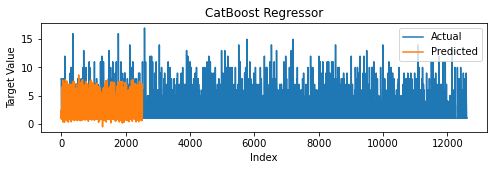

,Model,R2 Score,Adjusted R2,MSE,RMSE,MAE
0,Linear Regression,0.049717,0.048207,4.204704,2.050538,1.441631
1,Decision Tree Regressor,0.20065,0.199379,3.536875,1.880658,1.005551
2,Random Forest Regressor,0.482921,0.482099,2.287912,1.512585,0.859207
3,AdaBoost Regressor,0.287315,0.286182,3.153411,1.775784,1.427436
4,Bagging Regressor,0.46181,0.460954,2.381324,1.543154,0.872244
5,Gradient Boosting Regressor,0.57908,0.578411,1.86244,1.364713,0.871944
6,XGBoost Regressor,0.598637,0.597999,1.775906,1.332631,0.835274
7,LightGBM Regressor,0.60121,0.600576,1.764523,1.328353,0.8034
8,CatBoost Regressor,0.616981,0.616372,1.694739,1.301821,0.807372


In [663]:
evaluate_regression_models(X_train, X_test, y_train, y_test)

# Using bagging technique for the models with R2 higher than .45

# Hypertunning CatBoostRegressor

- Even after hyper tunning did'nt go above R2 score 0.61 and using baaging technique also did'nt improve it.
- tried hypertunning other models aslo but the highest i got is random forest regressor with 0.59 
- hence, from Regressor models CatBoostRegressor is the best model

# Time Series Models

## Feature Engineering for Time series models

In [664]:
df5=df3.copy()
df5

,date,spare,count
0,01-02-18,ENGINE OIL,8
1,01-02-18,CHAIN LUBRICATION,8
2,01-02-18,GENERAL SERVICE,6
3,01-02-18,AIR FILTER,5
4,01-02-18,BRAKE SHOE,4
...,...,...,...
12604,31-12-18,SHIELD SQUARE RUBBER,1
12605,31-12-18,CHAIN ADJUSTER,1
12606,31-12-18,CHAIN ADJUSTER PLATE,1
12607,31-12-18,BRAKE SHOE,1


In [665]:
df5['date']  = pd.to_datetime(df5['date'] , format='%d-%m-%y') #changing dtype to datetime
df5 = df5.set_index('date') # setting date column as index
df5 = df5.sort_index() # sorinding index by ascending order
df5

,spare,count
date,,
2017-05-30,ENGINE OIL,1
2017-05-31,DISC PAD,1
2017-05-31,CONSUMABLES,1
2017-05-31,CHAIN LUBRICATION,3
2017-05-31,3M OIL,2
...,...,...
2019-01-06,NUMBER PLATE CLAMP,1
2019-01-06,FORK OVERHUAL,1
2019-01-06,FORK OIL SEAL,1


In [666]:
from sklearn.preprocessing import LabelEncoder # doing label encoding
LE=LabelEncoder()
df5['spare'] = LE.fit_transform(df5['spare'])
df5

,spare,count
date,,
2017-05-30,144,1
2017-05-31,124,1
2017-05-31,106,1
2017-05-31,74,3
2017-05-31,2,2
...,...,...
2019-01-06,301,1
2019-01-06,172,1
2019-01-06,171,1


In [667]:
df5['count']=df5['count'].astype('int')
df5.describe()

,spare,count
count,12609.000000,12609.000000
mean,192.207074,2.223967
std,143.550617,2.103891
min,0.000000,1.000000
25%,78.000000,1.000000
50%,144.000000,1.000000
75%,314.000000,3.000000
max,481.000000,17.000000


# checking whether data is stationary or not

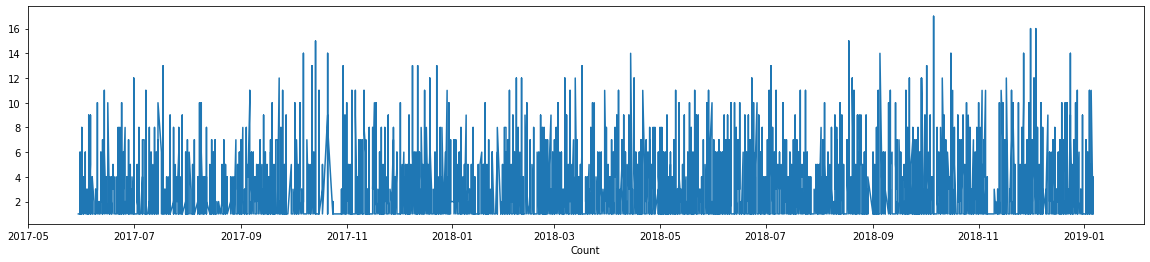

In [668]:
plt.figure(figsize=(20,4), facecolor='white')
plt.plot(df5['count'])
plt.xlabel('Count')
plt.show()

- This is a stationary data you can see that by noticing 2017-05 to 2017-11 and 2018-05 to 2018-11, you can see the similarity there

# Rolling statistics

In [669]:
def plot_rolling_statistics(time_series, window_size=12):
    plt.figure(figsize=(20,4), facecolor='white')
    rolling_mean = time_series.rolling(window=window_size).mean()
    rolling_std = time_series.rolling(window=window_size).std()
    plt.plot(time_series, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

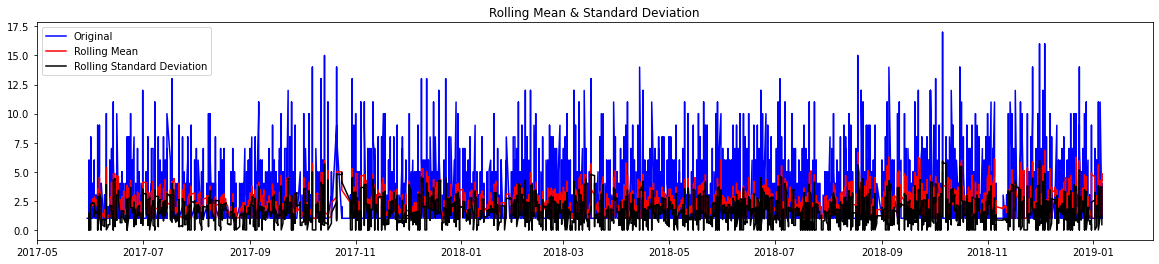

In [670]:
plot_rolling_statistics(time_series=df5['count'], window_size=12)

# Doing adfuller to confirm whether data is stationary or not

In [671]:
from statsmodels.tsa.stattools import adfuller
def adf_test(data):
    result=adfuller(data)
    labels=['ADF Test Statistics','p-value','Lags used','Number of Observation used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('Its stationary data')
    else:
        print('Its not stationary data')

In [672]:
adf_test(df5['count'])

ADF Test Statistics : -30.21245897855608
p-value : 0.0
Lags used : 14
Number of Observation used : 12594
Its stationary data


# Finding  partial correlation and auto correlation

In [673]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

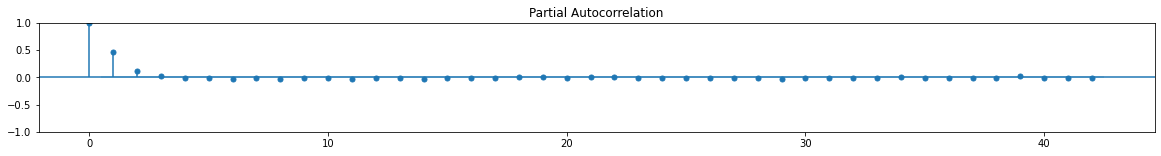

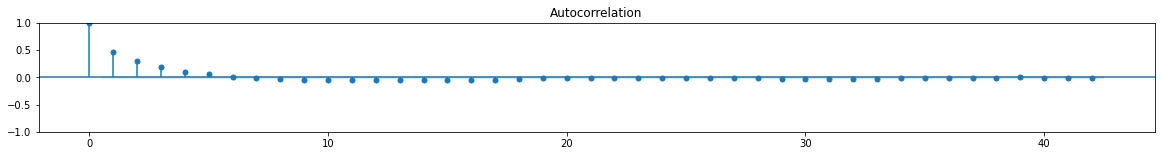

In [674]:
plot_pacf(df5['count'])
plot_acf(df5['count'])
plt.show()

# p , d and q values

- p=2 or 1 ,  from  partial correlation
- d=0   ,     times differncing done
- q=3 or 4   ,from  auto correlation

## Checking Outliers

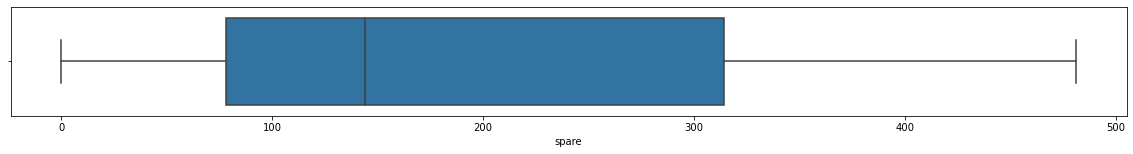

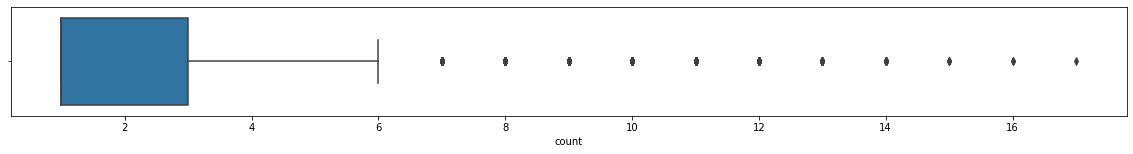

In [675]:
for i in df5:
    sns.boxplot(df4[i]) #boxplot
    plt.show()

- same as the i did for regressor model , removing outlier did'nt improve results, so I'm keeping them as they are.

# Exponential Smoothing Model

In [676]:
import statsmodels.api as sm 

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    count   No. Observations:                12609
Model:             ExponentialSmoothing   SSE                          48766.927
Optimized:                         True   AIC                          17065.457
Trend:                         Additive   BIC                          17102.668
Seasonal:                          None   AICC                         17065.466
Seasonal Periods:                  None   Date:                 Fri, 23 Dec 2022
Box-Cox:                          False   Time:                         23:12:27
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.4406003                alpha                 True
smoothing_trend            3.885e-

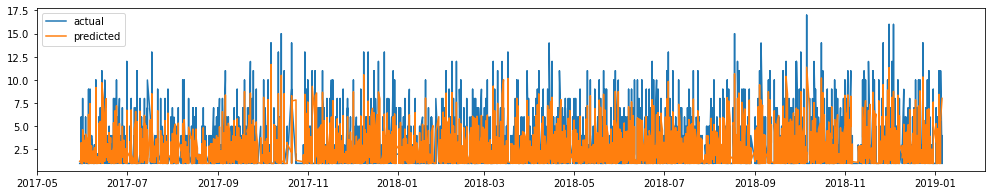

R2 score: 0.13
Adjusted R2 score: 0.13
Mean squared error: 3.87
Root mean squared error: 1.97
Mean absolute error: 1.16


In [677]:
X = df5['spare'] # predictor
y = df5['count'] #  target

model = sm.tsa.ExponentialSmoothing(y, trend='add', damped=True)
results = model.fit()
print(results.summary())

# Predict the target values for the predictor values in X
predictions = results.predict(start=X.index[0], end=X.index[-1])

# Plot the actual and predicted target values
plt.figure(figsize=(17,3))
plt.plot(y, label='actual')
plt.plot(predictions, label='predicted')
plt.legend()
plt.show()

# Truncate the y variable to the same length as the predictions variable
y_truncated = y.iloc[:len(predictions)]

# metrics
r2 = r2_score(y_truncated, predictions)
print(f'R2 score: {r2:.2f}')
n = len(y_truncated)
p = 1  # number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R2 score: {adj_r2:.2f}')
mse = mean_squared_error(y_truncated, predictions)
print(f'Mean squared error: {mse:.2f}')
rmse = np.sqrt(mse)
print(f'Root mean squared error: {rmse:.2f}')
mae = mean_absolute_error(y_truncated, predictions)
print(f'Mean absolute error: {mae:.2f}')

# ARIMA Model (ARIMA with eXogenous regressors is SARIMAX)

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                12609
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -25424.801
Date:                Fri, 23 Dec 2022   AIC                          50865.602
Time:                        23:12:46   BIC                          50925.140
Sample:                             0   HQIC                         50885.525
                              - 12609                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6477      0.058     45.637      0.000       2.534       2.761
spare         -0.0022      0.000    -15.192      0.000      -0.002      -0.002
ar.L1          0.7900      0.541      1.462      0.1

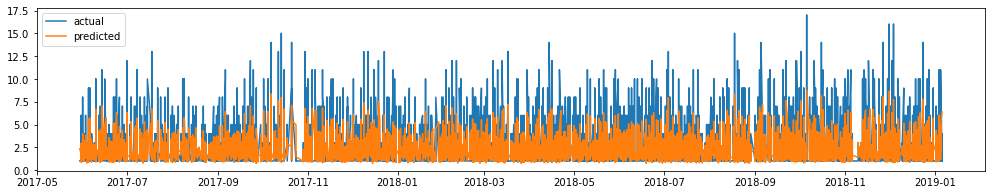

R2 score: 0.25
Adjusted R2 score: 0.25
Mean squared error: 3.31
Root mean squared error: 1.82
Mean absolute error: 1.17


In [678]:
X = df5['spare']
y = df5['count']

# Fit the ARIMA model with exogenous variables
model = sm.tsa.ARIMA(y, order=(2,0,3), exog=X)
results = model.fit()
print(results.summary())

# Predict the target values for the predictor values in X
predictions = results.predict(start=X.index[0], end=X.index[-1], exog=X)

# Plot the actual and predicted target values
plt.figure(figsize=(17,3))
plt.plot(y, label='actual')
plt.plot(predictions, label='predicted')
plt.legend()
plt.show()

# Truncate the y variable to the same length as the predictions variable
y_truncated = y.iloc[:len(predictions)]

# metrics
r2 = r2_score(y_truncated, predictions)
print(f'R2 score: {r2:.2f}')
n = len(y_truncated)
p = 1  # number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R2 score: {adj_r2:.2f}')
mse = mean_squared_error(y_truncated, predictions)
print(f'Mean squared error: {mse:.2f}')
rmse = np.sqrt(mse)
print(f'Root mean squared error: {rmse:.2f}')
mae = mean_absolute_error(y_truncated, predictions)
print(f'Mean absolute error: {mae:.2f}')

# SARIMAX Model 

                                     SARIMAX Results                                      
Dep. Variable:                              count   No. Observations:                12609
Model:             SARIMAX(2, 0, 3)x(2, 0, 3, 12)   Log Likelihood              -25932.042
Date:                            Fri, 23 Dec 2022   AIC                          51888.083
Time:                                    23:16:28   BIC                          51977.389
Sample:                                         0   HQIC                         51917.968
                                          - 12609                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spare         -0.0021      0.000    -15.166      0.000      -0.002      -0.002
ar.L1         -0.0219      0.031   

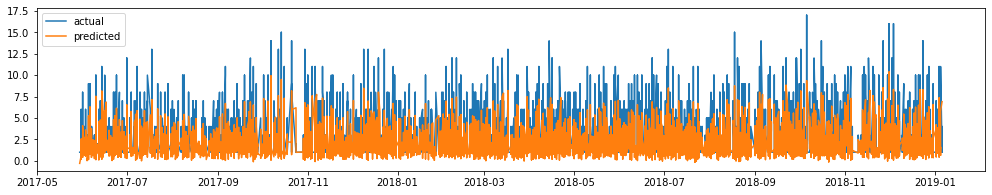

R2 score: 0.19
Adjusted R2 score: 0.19
Mean squared error: 3.58
Root mean squared error: 1.89
Mean absolute error: 1.15


In [679]:
# Define the predictor and target variables
X = df5['spare']
y = df5['count']

# Specify the SARIMAX model
model = sm.tsa.SARIMAX(endog=y, exog=X, order=(2,0,3), seasonal_order=(2,0,3,12))

# Fit the model
results = model.fit()
print(results.summary())

# Predict the target values for the predictor values in X
predictions = results.predict(start=X.index[0], end=X.index[-1], exog=X)

# Plot the actual and predicted target values
plt.figure(figsize=(17,3))
plt.plot(y, label='actual')
plt.plot(predictions, label='predicted')
plt.legend()
plt.show()

# Truncate the y variable to the same length as the predictions variable
y_truncated = y.iloc[:len(predictions)]

# metrics
r2 = r2_score(y_truncated, predictions)
print(f'R2 score: {r2:.2f}')
n = len(y_truncated)
p = 1  # number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R2 score: {adj_r2:.2f}')
mse = mean_squared_error(y_truncated, predictions)
print(f'Mean squared error: {mse:.2f}')
rmse = np.sqrt(mse)
print(f'Root mean squared error: {rmse:.2f}')
mae = mean_absolute_error(y_truncated, predictions)
print(f'Mean absolute error: {mae:.2f}')

# Best Model 
### CatBoostRegressor with default parameter 
- R2	0.616981
- Adjusted R2	0.616372	
- MSE 1.694739	
- RMSE 1.301821	
- MAE 0.807372

# Report on Challenges faced

- All columns had Dtype as object 
- Cleand all column by captalizing string, removing X , removing space before and after the string and removing 0 len strings.
- There was null valus in dataframe, removed them.
- Removed duplicates.
- After cleaning reduced spare parts unique from 503 to 482.

- At first I tried classifier model to predict spare parts for the particular date , it was complex.
- Then I used groupby function to create new datafram containing date, spare and its count on that spacific day.
- Decided to use regressor model to predict spare parts count on particular date.

### Regressor models
- Split date column into day,month and year for ML interpretation.
- Did label encoding for spare column.
- Changed all column Dtype to int,
- Checked outliers there is some outliers in count column, removing them dosent improve results, so I kept them as they are.
- Built a fuction to run several regressor model and store the score in dataframe and show the prediction in plot.

### These are the regressor models I did
     1.Linear Regression
     2.Decision Tree Regressor
     3.Random Forest Regressor
     4.AdaBoost Regressor
     5.Bagging Regressor
     6.Gradient Boosting Regressor
     7.XGB Regressor
     8.LGBM Regressor
     9.CatBoost Regressor (Over all Best Model)

- Tried bagging technique and hypertunning yet score did'nt improve.
- Hence decided CatBoostRegressor with default parameters as best model.
- Since the best R2 score I got is 0.61 , decided to try Time series models.

### Time series models

- Changed data column dtype to datetime.
- Made datime column as my index.
- Did label encoding for spare column .
- astype the count column.
- Checked whether my data is stationary or not
- for that I used rolling stone plot, and adfuller test.
- To find pdq value for ARIMA and SARIMAX model, did acf and pacf plots.
- Checked outliers there is some outliers in count column, removing them dosent improve results, so I kept them as they are.
- Since I had Extra predictor variable (eXogenous regressors=spare column) apart from date index , it was bit complex for implementing time series models.
- Using metrics to evaluate the time series model was bit complex.
- Also used plots to see difference of prediction from actual data.

### These are the Time Series models I did 
     1.Exponential Smoothing Model
     2.ARIMA (Best in time series with R2=0.25)
     3.SARIMAX
    